Exercício imagens tumores
=========================

Classificação de tipos de tumores
=================================

**Imagens na pasta Datasets/Exercicio_Tumores**

**Passos:**

1. Carregue o conjunto de imagens.
2. Realize o pre processamento.
3. Divida os dados em recursos (X) e rótulos (y).
4. Divida o conjunto de dados em conjuntos de treinamento, validação e teste.
5. Treinamento: 
   1. Definição de arquitetura:
      1. Definir quantas camadas são necessárias para o problema
      2. A quantidade de neurônios em cada camada.
      3. A função de ativação de cada camada.
      4. Regularização - dropout.
      5. A função de ativação da saída.
         * softmax (saída não binária).
         * sigmoid (saída binária).
   2. `.compile`: Definição dos otimizadores.
   3. Regularização - earlystop.
   4. `.fit`: Adicionar conjuntos de treinamento e validação; e determinar a quantidade de épocas.
6. Avalie o desempenho do modelo usando métricas como acurácia, matriz de confusão, etc. 

## Imports

In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

from keras.layers import Dense, Activation, Dropout, Flatten
from keras.models import Sequential
from keras.callbacks import EarlyStopping

import pathlib
import cv2
import os

import matplotlib.pyplot as plt

import sys 
sys.path.insert(1, '../')
from src.plot import plot_heatmap
from src.train import get_all_subsets, results_regression

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### 1. Aquisição dos dados


In [5]:
path = '../../Datasets/Exercicio_Tumores'
data = pathlib.Path(path)

In [6]:
data

PosixPath('../../Datasets/Exercicio_Tumores')

In [7]:
list(data.glob('*/*.jpg'))[:5]

[PosixPath('../../Datasets/Exercicio_Tumores/normal/N_23.jpg'),
 PosixPath('../../Datasets/Exercicio_Tumores/normal/N_170.jpg'),
 PosixPath('../../Datasets/Exercicio_Tumores/normal/N_326.jpg'),
 PosixPath('../../Datasets/Exercicio_Tumores/normal/N_188.jpg'),
 PosixPath('../../Datasets/Exercicio_Tumores/normal/N_119.jpg')]

In [8]:
list(data.glob('glioma_tumor/*.jpg'))[:5]

[PosixPath('../../Datasets/Exercicio_Tumores/glioma_tumor/G_6.jpg'),
 PosixPath('../../Datasets/Exercicio_Tumores/glioma_tumor/G_169.jpg'),
 PosixPath('../../Datasets/Exercicio_Tumores/glioma_tumor/G_796.jpg'),
 PosixPath('../../Datasets/Exercicio_Tumores/glioma_tumor/G_836.jpg'),
 PosixPath('../../Datasets/Exercicio_Tumores/glioma_tumor/G_170.jpg')]

In [9]:
disease = {
    "glioma_tumor": list(data.glob('glioma_tumor/*.jpg')),
    "meningioma_tumor": list(data.glob('meningioma_tumor/*.jpg')),
    "normal": list(data.glob('normal/*.jpg')),
    "pituitary_tumor" : list(data.glob('pituitary_tumor/*.jpg')),       
}

In [10]:
disease.keys()

dict_keys(['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor'])

In [11]:
labels = {
    "glioma_tumor" : 0,
    "meningioma_tumor": 1,
    "normal": 2,
    "pituitary_tumor": 3
}

In [12]:
os.listdir(path)

['normal', 'glioma_tumor', 'pituitary_tumor', 'meningioma_tumor']

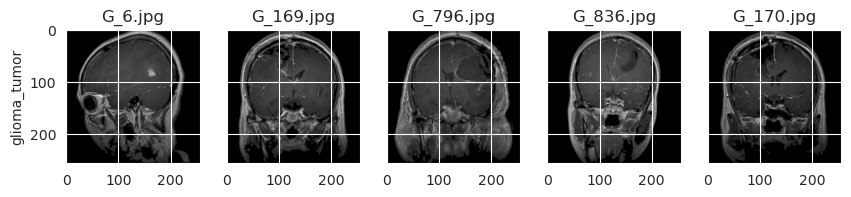

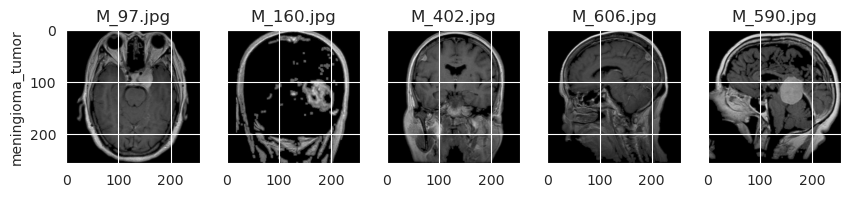

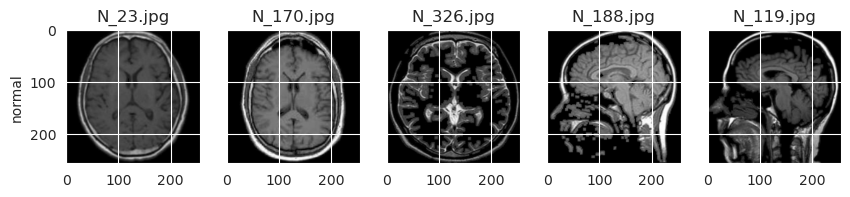

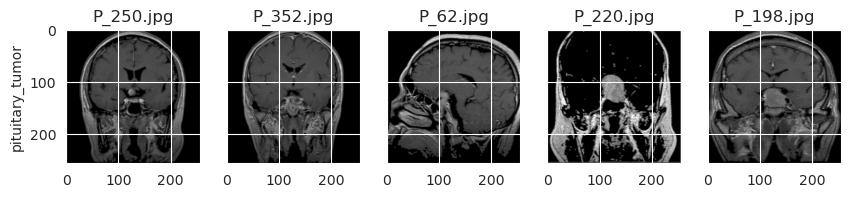

In [13]:
directory = os.listdir(path)

for each in disease.keys():
    plt.figure(figsize=(10, 10))
    currentFolder = path + '/' + each
    for i, file in enumerate(os.listdir(currentFolder)[0:5]):
        fullpath = path + '/' + each + "/" + file
        img=cv2.imread(fullpath)
        ax=plt.subplot(1,5,i+1)
        ax.set_title(file)
        if(i == 0):
            ax.set_ylabel(each)
        else:
            ax.set_yticklabels([])
        plt.imshow(img)

## Carregamento dos dados

In [14]:
X = []
Y = []
for name, diseases in disease.items():
    for disease in diseases:
        img = cv2.imread(str(disease))
        img = img.astype('float32') / 255.0
        X.append(img)
        Y.append(labels[name])     

In [15]:
X = np.array(X)
Y = np.array(Y)

In [16]:
X_train, X_val, X_test, y_train, y_val, y_test = get_all_subsets(X, Y)

In [17]:
print('X_train: ', X_train.shape)
print('X_val: ', X_val.shape)
print('X_test: ', X_test.shape)
print('y_train: ', y_train.shape)
print('y_val: ', y_val.shape)
print('y_test: ', y_test.shape)

X_train:  (1980, 256, 256, 3)
X_val:  (496, 256, 256, 3)
X_test:  (620, 256, 256, 3)
y_train:  (1980,)
y_val:  (496,)
y_test:  (620,)


In [18]:
hot = OneHotEncoder()
y_train = hot.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_val = hot.fit_transform(np.array(y_val).reshape(-1, 1)).toarray()
y_test = hot.transform(np.array(y_test).reshape(-1, 1)).toarray()

In [19]:
seq = Sequential()
seq.add(Flatten(input_shape = (256, 256, 3)))
seq.add(Dense(512))
seq.add(Activation('relu'))
seq.add(Dropout(0.3))
seq.add(Dense(256))
seq.add(Activation('relu'))
seq.add(Dense(128))
seq.add(Dropout(0.3))
seq.add(Activation('relu'))
seq.add(Dense(64))
seq.add(Activation('relu'))
seq.add(Dense(4))
seq.add(Activation('softmax'))

seq.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics=['accuracy'])

seq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 dense (Dense)               (None, 512)               100663808 
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               3

In [20]:
es = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10, verbose = 1, mode = 'auto')

In [21]:
historico = seq.fit(X_train, 
                             y_train, 
                             epochs = 2, 
                             verbose = 1,
                             validation_data = (X_val, y_val),
                             callbacks = [es])

Epoch 1/2


2023-10-25 09:05:47.433001: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1557135360 exceeds 10% of free system memory.


62/62 [==============================] - 89s 1s/step - loss: 9.0608 - accuracy: 0.2803 - val_loss: 1.3577 - val_accuracy: 0.3266
Epoch 2/2
62/62 [==============================] - 88s 1s/step - loss: 1.6056 - accuracy: 0.2904 - val_loss: 1.3445 - val_accuracy: 0.3125


In [22]:
y_pred = seq.predict(X_test)

print("Accuracy score:\n\r")
accuracy_score(y_test.argmax(1), y_pred.argmax(1))

2023-10-25 09:08:45.190814: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 487587840 exceeds 10% of free system memory.


20/20 [==============================] - 2s 79ms/step
Accuracy score:



0.34838709677419355

In [23]:

print("Confusion Matrix:\n\r")
confusion_matrix(y_test.argmax(1), y_pred.argmax(1))

Confusion Matrix:



array([[170,  28,   1,   0],
       [144,  32,   9,   1],
       [ 50,  26,  13,   0],
       [140,   5,   0,   1]])